In [1069]:
%matplotlib inline

from collections import namedtuple
from typing import Union

from matplotlib import pyplot

import geopandas as gpd
import numpy as np

import shapely.ops
import shapely.affinity as affine
import shapely.geometry as geom

from weavingspace.symmetry import KMP_Matcher
from weavingspace.symmetry import Symmetries
from weavingspace.symmetry import Symmetry
import weavingspace.tiling_utils as tiling_utils
from weavingspace.tile_unit import TileUnit

### A test polygon

In [1070]:
pt_sets = [
  [(50, 50), (150, -50), (50, -50), (-50, -150)], # irregular     C1
  [(30, 30), (35, -35), (-30, -30), (-50, 50)],   # kite          D1
  [(50, 50), (150, -50), (-50, -50), (-150, 50)], # parallelogram C2
  [(75, 50), (75, -50), (-75, -50), (-75, 50)],   # rectangle     D2
  [(50, 50), (150, -50), (50, -50), (-50, -150),  # star thing    C4
   (-50, -50), (-150, 50), (-50, 50), (50, 150)],
  [(50, 50), (50, -50), (-50, -50), (-50, 50)],   # square        D4
]
polys = [geom.Polygon(pts) for pts in pt_sets]

So... cyclic symmetries Cn may exist independent of reflection symmetries. But reflection symmetries only exist in pairs with corresponding number of rotational symmetries. This means that there should be a logic in the symmetry detection code like

However... if the question is one of matching a polygon to some other polygon (not finding the 'internal' symmetries of a polygon), then it is possible for the matching transform to be a reflection; it could also be a rotation at the same time, but a standalone reflection becomes a possibility for a shape with C1 as its symmetry group.

Make a C1 polygon and its mirror image - note we have to `shapely.normalize` the affine transformed shape because `shapely` reverses its winding order.

In [1077]:
Transform = namedtuple("Transform", "type angle centre translation transform")
StraightLine = namedtuple("StraightLine", "A B C")

class Shape_Matcher:
  shape: geom.Polygon
  s1: Symmetries
  other: geom.Polygon
  centre: geom.Point
  translation: tuple[float]
  matches: list[Transform]
  identity_transform: tuple[float] = (1, 0, 0, 1, 0, 0)
  
  def __init__(self, shape: geom.Polygon):
    self.shape = shape
    self.s1 = Symmetries(shape)

  def get_polygon_matches(self, shape2: geom.Polygon):
    s2 = Symmetries(shape2)
    if self.s1.symmetry_group != s2.symmetry_group:
      print("No matches")
      return []
    else:
      match_rot, rots, offset = self._get_rotation_matches(s2)
      match_ref, refs = self._get_reflection_matches(s2)
      if match_rot and match_ref:
        print(f"Rotation and reflection matches found")
        return rots + refs, offset
      elif match_rot:
        print(f"Only rotation matches found")
        return rots, offset
      elif match_ref:
        print(f"Only reflection matches found")
        return refs, offset
      else:
        print (f"No matches found")
        return [], offset

  def _get_reflection_matches(self, s2:Symmetries):
    tr = (1, 0, 0, 1, 0, 0)
    ctr1 = self.s1.polygon.centroid
    ctr2 = s2.polygon.centroid
    c = ((ctr1.x + ctr2.x) / 2, (ctr1.y + ctr2.y) / 2)
    matches = self.s1.matcher.find_matches(s2.p_code_r)
    if len(matches) == 0:
      return False, tr
    reflections1 = self.s1.get_reflections(matches)
    reflections2 = s2.get_reflections(matches)
    angles = [(ref1.angle + ref2.angle) / 2
              for ref1, ref2 in zip(reflections1, reflections2)]
    trs = [tiling_utils.get_reflection_transform(angle, c)
           for angle in angles]
    ctrs2r = [affine.affine_transform(ctr2, tr) for tr in trs]
    dxdys = [(ctr1.x - ctr2r.x, ctr1.y - ctr2r.y) for ctr2r in ctrs2r]
    return True, [Transform(
      "reflection", angle, geom.Point(c), dxdy,
      tiling_utils.combine_transforms(
        [tiling_utils.get_reflection_transform(angle, c),
        (1, 0, 0, 1, dxdy[0], dxdy[1])])) 
      for angle, dxdy in zip(angles, dxdys)]

  def _get_rotation_matches(self, s2:Symmetries):
    matches = self.s1.matcher.find_matches(s2.p_code)
    if len(matches) == 0:
      return False, [Transform("null", 0, geom.Point(0, 0), (0, 0),
                               (1, 0, 0, 1, 0, 0))], 0
    else:
      transforms = []
      # get lists of polygon corners aligned correctly to measure the angle
      p1_corners = tiling_utils.get_corners(self.shape, repeat_first = False)
      p2_corners = tiling_utils.get_corners(s2.polygon, repeat_first = False)
      for offset in matches:
        a, c = self.get_angle_between_polygons(p1_corners, p2_corners, offset)
        if a == "translation":
          print("One of the rotation matches is a translation.")
          transforms.append(
            Transform("translation", None, None, c, (1, 0, 0, 1, c[0], c[1])))
        elif a == "identity":
          transforms.append(
            Transform("identity", None, None, c, (1, 0, 0, 1, 0, 0)))
          break
        else:
          transforms.append(Transform("rotation", a, c, (0, 0),
            tiling_utils.get_rotation_transform(a, (c.x, c.y))))
      return True, transforms, offset

  def get_angle_between_polygons(self, corners1:list[geom.Point], 
      corners2:list[geom.Point], offset:int) -> tuple[Union[float,geom.Point]]:
    corners2 = corners2[offset:] + corners2[:offset]
    dists = [p1.distance(p2) for p1, p2 in zip(corners1, corners2)]
    if all([np.isclose(dists[0], d, atol = 1e-4, rtol = 1e-4) for d in dists]):
      if np.isclose(dists[0], 0, atol = 1e-4, rtol  = 1e-4):
        return "identity", (0, 0)
      else:
        return "translation", (corners1[0].x - corners2[0].x,
                               corners1[0].y - corners2[0].y)
    ordered_dists = sorted([(i, d) for i, d in enumerate(dists)], 
                           key = lambda x: x[1])
    AB = ordered_dists[-2:]
    p1A, p1B = corners1[AB[0][0]], corners1[AB[1][0]]
    p2A, p2B = corners2[AB[0][0]], corners2[AB[1][0]]
    perpAA = self.get_straight_line(p1A, p2A, True)
    perpBB = self.get_straight_line(p1B, p2B, True)
    centre = self.get_intersection(perpAA, perpBB)
    angle = -tiling_utils.get_inner_angle(p1A, centre, p2A)
    if angle < -179:
      angle = angle + 360
    elif angle > 180:
      angle = angle - 360
    return angle, centre

  def get_straight_line(self, p1:geom.Point, p2:geom.Point, 
                        perpendicular:bool = False) -> StraightLine:
    if perpendicular:
      ls = affine.rotate(geom.LineString([p1, p2]), 90)
      pts = [p for p in ls.coords]
      x1, y1 = pts[0]
      x2, y2 = pts[1]
    else:
      x1, y1 = p1.x, p1.y
      x2, y2 = p2.x, p2.y
    return StraightLine(y1 - y2, x2 - x1, x1 * y2 - x2 * y1)

  def get_intersection(self, line1:StraightLine, 
                       line2:StraightLine) -> geom.Point:
    x_set, y_set = False, False
    denominator = line1.A * line2.B - line2.A * line1.B
    if np.isclose(line1.A, 0, atol = 1e-4, rtol = 1e-4):
      y = -line1.C / line1.B
      y_set = True
    elif np.isclose(line2.A, 0, atol = 1e-4, rtol = 1e-4):
      y = -line2.C / line2.B
      y_set = True
    if np.isclose(line1.B, 0, atol = 1e-4, rtol = 1e-4):
      x = -line1.C / line1.A
      x_set = True
    elif np.isclose(line2.A, 0, atol = 1e-4, rtol = 1e-4):
      x = -line2.C / line2.A
      x_set = True
    if np.isclose(denominator, 0, atol = 1e-4, rtol = 1e-4):
      return None
    x = x if x_set else (line1.B * line2.C - line2.B * line1.C) / denominator
    y = y if y_set else (line1.C * line2.A - line2.C * line1.A) / denominator
    return geom.Point(x, y)


In [1078]:
def draw_rotation(ax:pyplot.Axes, tr:Transform, radius = 100):
  x, y = tr.centre.x, tr.centre.y
  axis = geom.LineString([(x, y), (x + radius * 1.25, y)])
  arc = geom.LineString([
    geom.Point(x + radius * np.cos(np.radians(a)),
                y + radius * np.sin(np.radians(a)))
    for a in np.linspace(0, tr.angle, 50)])
  gpd.GeoSeries([tr.centre]).plot(ax = ax, color = "r")
  gpd.GeoSeries([axis, arc]).plot(ax = ax, color = "r", lw = .5)
  ax.set_title(f"{tr.type} {np.round(tr.angle, 2)}")

def draw_reflection(ax:pyplot.Axes, tr:Transform, 
                    w = 5, mirror_length = 100):
  x, y = tr.centre.x, tr.centre.y
  dx, dy = tr.translation
  r = np.sqrt(tr.translation[0] ** 2 + tr.translation[1] ** 2) 
  mirror = geom.LineString([
    (x - mirror_length / 2 * np.cos(np.radians(tr.angle)), 
      y - mirror_length / 2 * np.sin(np.radians(tr.angle))),
    (x + mirror_length / 2 * np.cos(np.radians(tr.angle)), 
      y + mirror_length / 2 * np.sin(np.radians(tr.angle)))])
  gpd.GeoSeries([mirror]).plot(
    ax = ax, color = "r", lw = 1, ls = "dashdot")
  no_slide = np.isclose(r, 0, rtol = 1e-6, atol = 1e-6)
  if not no_slide:
    pyplot.arrow(x - dx / 2, y - dy / 2, dx, dy, length_includes_head = True,
                 width = w, fc = "k", ec = None, head_width = w * 6, zorder = 5)
  ax.set_title(f"{tr.type} {np.round(tr.angle, 2)}")

def draw_translation(ax:pyplot.Axes, tr:Transform, c:geom.Point, w:float = 5):
  gpd.GeoSeries([c]).plot(ax = ax, color = "b")
  pyplot.arrow(c.x, c.y, tr.translation[0], tr.translation[1], lw = 0.5,
               width = w, fc = "b", ec = None, head_width = w * 6, zorder = 5)
  ax.set_title(f"{tr.type} {tuple([np.round(x, 2) for x in tr.translation])}")


In [1084]:
# tiles = TileUnit(tiling_type = "hex-slice", n = 12, offset = 0)
# poly1 = tiles.tiles.geometry[0]
# poly2 = affine.translate(tiles.tiles.geometry[2], 1000, 0)
poly1 = affine.scale(tiling_utils.get_regular_polygon(500, 6), 1, 1)
p0 = tiling_utils.get_corners(poly1)[0]
poly2 = affine.translate(affine.rotate(poly1, 120, p0), 0, 0)
# poly1 = tiling_utils.get_regular_polygon(500, 4)
# poly2 = affine.rotate(poly1, 150, (250, 250))

In [1085]:
matcher = Shape_Matcher(poly1)
trs, offset = matcher.get_polygon_matches(poly2)

One of the rotation matches is a translation.
Rotation and reflection matches found


In [1086]:
trs

[Transform(type='rotation', angle=-119.99999998764929, centre=<POINT (-144.338 -250)>, translation=(0, 0), transform=[-0.499999999813319, 0.8660254038922189, -0.8660254038922189, -0.499999999813319, 6.077804073356674e-07, -499.9999998980064]),
 Transform(type='rotation', angle=-60.00000010023976, centre=<POINT (0 -500)>, translation=(0, 0), transform=[0.49999999848487664, 0.8660254046591955, -0.8660254046591955, 0.49999999848487664, 433.0127006252431, -250.00000034082038]),
 Transform(type='translation', angle=None, centre=None, translation=(433.012702, 250.0), transform=(1, 0, 0, 1, 433.012702, 250.0)),
 Transform(type='rotation', angle=60.000000079769904, centre=<POINT (-433.013 250)>, translation=(0, 0), transform=[0.49999999879427826, -0.8660254044805624, 0.8660254044805624, 0.49999999879427826, -1.4364050002768636e-06, 499.99999963482543]),
 Transform(type='rotation', angle=120.00000031306996, centre=<POINT (-288.675 0)>, translation=(0, 0), transform=[-0.5000000047320506, -0.8660

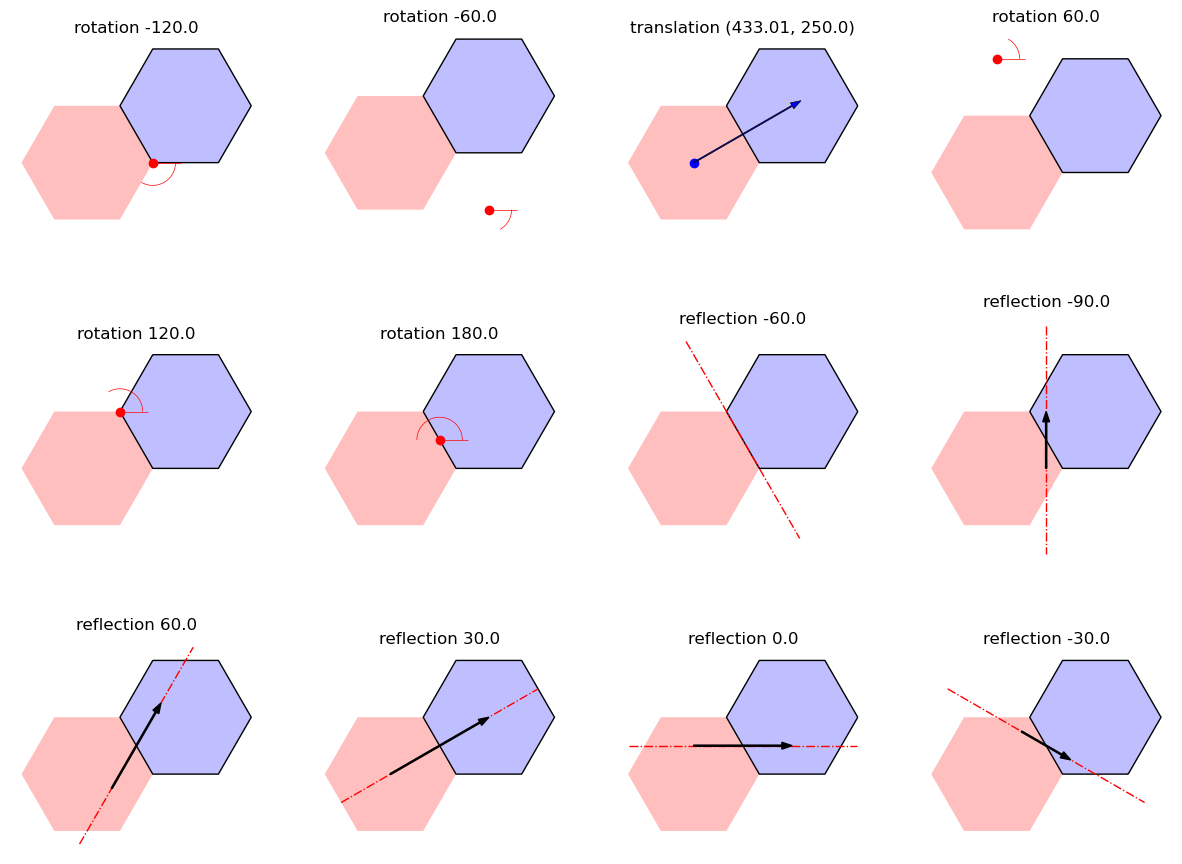

In [1087]:
n = len(trs)
nc = int(np.ceil(np.sqrt(n)))
nr = int(np.ceil(n / nc))

fig = pyplot.figure(figsize = (15, 15 * nr/nc))

for i, tr in enumerate(trs):
  ax = fig.add_subplot(nr, nc, i + 1)
  gpd.GeoSeries(
  [poly1, poly2, affine.affine_transform(poly2, tr.transform)]).plot(
    ax = ax, fc = ["#0000ff40", "#ff000040", "#00000000"], lw = [0, 0, 1], 
    ec = "k")
  if tr.type == "rotation":
    draw_rotation(ax, tr, radius = 100)
  elif tr.type == "reflection":
    draw_reflection(ax, tr, w = 5, mirror_length = 1000)
  elif tr.type == "translation":
    draw_translation(ax, tr, c = poly2.centroid)
  elif tr.type == "identity":
    ax.set_title(f"{tr.type}")
  pyplot.axis("off")
